In [1]:
#Getting data
import os
from urllib.request import urlretrieve

Carina_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table2.dat"
Fornax_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table3.dat"
Sculptor_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table4.dat"
Sextans_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table5.dat"

dSph = {Carina_url:"Carina.txt",Fornax_url:"Fornax.txt",Sculptor_url:"Sculptor.txt",Sextans_url:"Sextans.txt"}
def get_data(filename, url):
    if not os.path.exists(filename):
        urlretrieve(url, filename)

for i in dSph:
    get_data(dSph[i],i)

In [2]:
import pandas as pd
import pylab
import math
%matplotlib inline


In [3]:
def Nbad(Mmb):
    Nbad = [] 
    for i in range(len(Mmb)):
        if Mmb[i] == '     ':
            Mmb[i] = Mmb[i-1]
        if float(Mmb[i]) < 0.5:
            Nbad.append(i+1)
            
    return Nbad

In [4]:
def Fe_H(name, SigMg,DEd, DEdc, DEm, DEmc, DEs, DEsc,RAh, RAhc, RAm, RAmc, RAs, RAsc):
    #Calculating Fe/H, not reduced
    Fehzw84 = []
    Fehcg97 = []
    dist = [] #arcmin
    for i in range(len(SigMg)):
        distt = math.cos( float(((DEd[i]-DEdc)*60+ (DEm[i]-DEmc) + (DEs[i]-DEsc)/60) * math.pi/180/60))* math.cos(float(((RAh[i]-RAhc)*60 + (RAm[i]-RAmc) + (RAs[i]-RAsc)/60)* math.pi/12/60))
        dist.append(math.acos(distt)*60*180/math.pi)
        try:
            z = float(SigMg[i])
            #Fehzw84.append(round((1.93*z - 2.34),2))
            Fehcg97.append(round((1.76 *z - 2.11),2))
        except:
            #Fehzw84.append(None)
            Fehcg97.append(None)   
    
    #distribution of Fe/H
    Fe97 = Fehcg97.copy()
    
    count = []
    value = []
    n = 1
    for i in range(len(Fe97)):
        if Fe97[i] != '+' and Fe97[i] != None:
            for j in range(i+1,len(Fe97)):
                if Fe97[i] == Fe97[j]:
                    n += 1
                    Fe97[j] ='+'
            count.append(n)
            value.append(Fe97[i])
            n=1
    

    return pylab.figure(), pylab.plot(dist, Fehcg97, '.y', label='Fe/H(cg97)  radial dependence' ), pylab.plot(count, value,'.', label='distribution of Fe/H(cg97)') ,pylab.legend(loc='upper right'),pylab.title(name),pylab.xlabel('Radius arcmin, N'),pylab.ylabel('Fe/H CG97');

In [5]:

def V(name, HV, e_HV, Target,DEd, DEdc, DEm, DEmc, DEs, DEsc,RAh, RAhc, RAm, RAmc, RAs, RAsc):
    
    Vmed = [] #<V>, km/s
    w = e_HV[0]**(-2) 
    wV = e_HV[0]**(-2) * HV[0]
    dist2 = [] #arcmin
    for i in range(len(HV)-1): 
        if Target[i] == Target[i+1]:
            w += e_HV[i+1]**(-2) 
            wV += e_HV[i+1]**(-2) * HV[i+1]
        else:
            distt2 = math.cos( float(((DEd[i]-DEdc)*60+ (DEm[i]-DEmc) + (DEs[i]-DEsc)/60) * math.pi/180/60))*math.cos(float(((RAh[i]-RAhc)*60 + (RAm[i]-RAmc) + (RAs[i]-RAsc)/60)* math.pi/12/60))
            dist2.append(math.acos(distt2)*60*180/math.pi)
            Vmed.append(wV/w)
            w = e_HV[i+1]**(-2) 
            wV = e_HV[i+1]**(-2) * HV[i+1]
    return pylab.figure(), pylab.plot(dist2, Vmed, '.r', label = 'velocity radial dependence' ), pylab.legend(loc='upper right'), pylab.title(name),pylab.xlabel('Radius arcmin'),pylab.ylabel('<HV> km/s');

In [6]:
#center coordinates ICRS coord.(hh:mm:ss) (-dd:mm:ss)
Carina = [6, 41, 36.7, 50, 57,58 ]
Fornax = [2, 39, 59.3,34, 26, 57]
Sculptor = [1, 0,9.4, 33, 42, 32]
Sextans = [10, 13, 2.9, 1, 36, 53]
dwarflist = [Carina, Fornax, Sculptor, Sextans]
dSphs = ["Carina.txt","Fornax.txt","Sculptor.txt","Sextans.txt"]

In [7]:
def simple_analysis(filename):

    dataall = pd.read_table(filename, sep = '\t', header = 0,skiprows = range(1,3))
    

    filename2 = filename.split(".")
    filename2.insert(1,'I.')
    dwarfname = filename2[0]
    filename2 = ''.join(filename2)
    dataall.to_csv(filename2,sep = '\t')
    
    data = pd.read_csv(filename2, sep = '\t', header = 0, skiprows = Nbad(dataall['Mmb']))
    if 'Unnamed: 0' in data.columns:
        del data['Unnamed: 0']
    
    dwarf = dSphs.index(filename)
    fig1 = Fe_H(dwarfname, data['SigMg'], data['DEd'], dwarflist[dwarf][3], 
                 data['DEm'], dwarflist[dwarf][4], data['DEs'], dwarflist[dwarf][5],data['RAh'],
                 dwarflist[dwarf][0], data['RAm'], dwarflist[dwarf][1], data['RAs'], dwarflist[dwarf][2])
    fig2 = V(dwarfname, 
            data['HV'], data['e_HV'],data['Target'],data['DEd'], dwarflist[dwarf][3], data['DEm'] , 
            dwarflist[dwarf][4], data['DEs'], dwarflist[dwarf][5],data['RAh'], 
         dwarflist[dwarf][0], data['RAm'], dwarflist[dwarf][1], data['RAs'], dwarflist[dwarf][2])                                                                                               
    return fig1, fig2


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


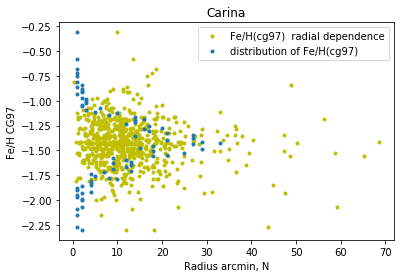

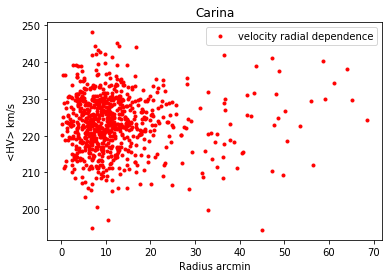

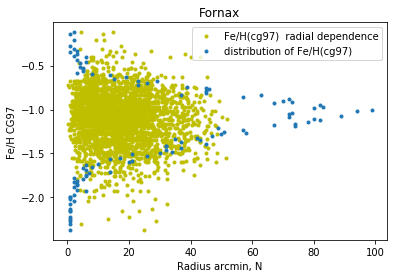

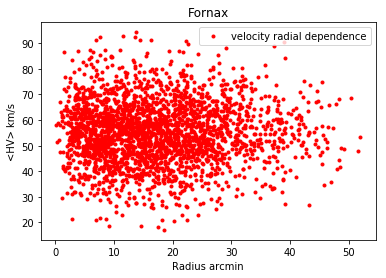

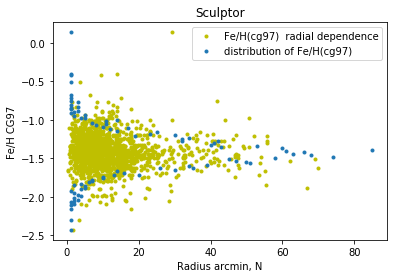

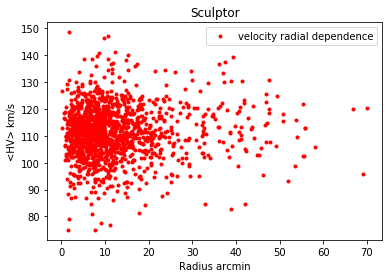

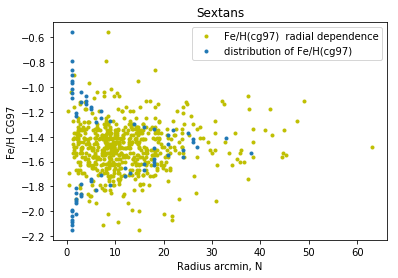

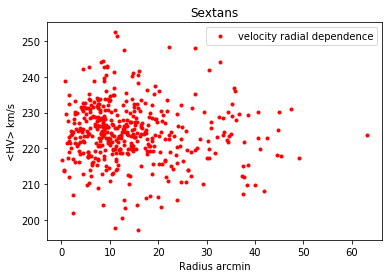

In [8]:
for i in dSphs:
    simple_analysis(i)